### Integrates STREAM with pyscnet
A python package - [STREAM](https://github.com/pinellolab/STREAM) was designed for reconstructing cell trajectory for single cell transcriptomic data. This tutorial guides how to integrate STREAM with pyscnet for gene regulatory network along the cell differential trajectory.

In [1]:
import stream as st

/home/mwu/miniconda3/envs/stream/lib/python3.6/site-packages/anndata/core/anndata.py:17: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


In [2]:
st.set_figure_params(dpi=80,style='white',figsize=[5.4,4.8],
                     rc={'image.cmap': 'viridis'})

### Data resource
Data was obtained from [Nestorowa, S. et al](https://doi.org/10.1182/blood-2016-05-716480). The preprocessing steps are followed from [stream tutorial](https://nbviewer.jupyter.org/github/pinellolab/STREAM/blob/master/tutorial/prep_nestorowa2016.ipynb)

In [3]:
adata=st.read(file_name='./data/data_nestorowa2016.tsv.gz',workdir='./result')

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Saving results in: ./result


In [4]:
adata.var_names_make_unique()
st.add_metadata(adata,file_name='./data/metadata.tsv')
adata.obs.head()

,label,label_color
HSPC_025,MPP,#eea113
HSPC_031,HSC,#40bdbd
HSPC_037,HSC,#40bdbd
LT-HSC_001,HSC,#40bdbd
HSPC_001,HSC,#40bdbd


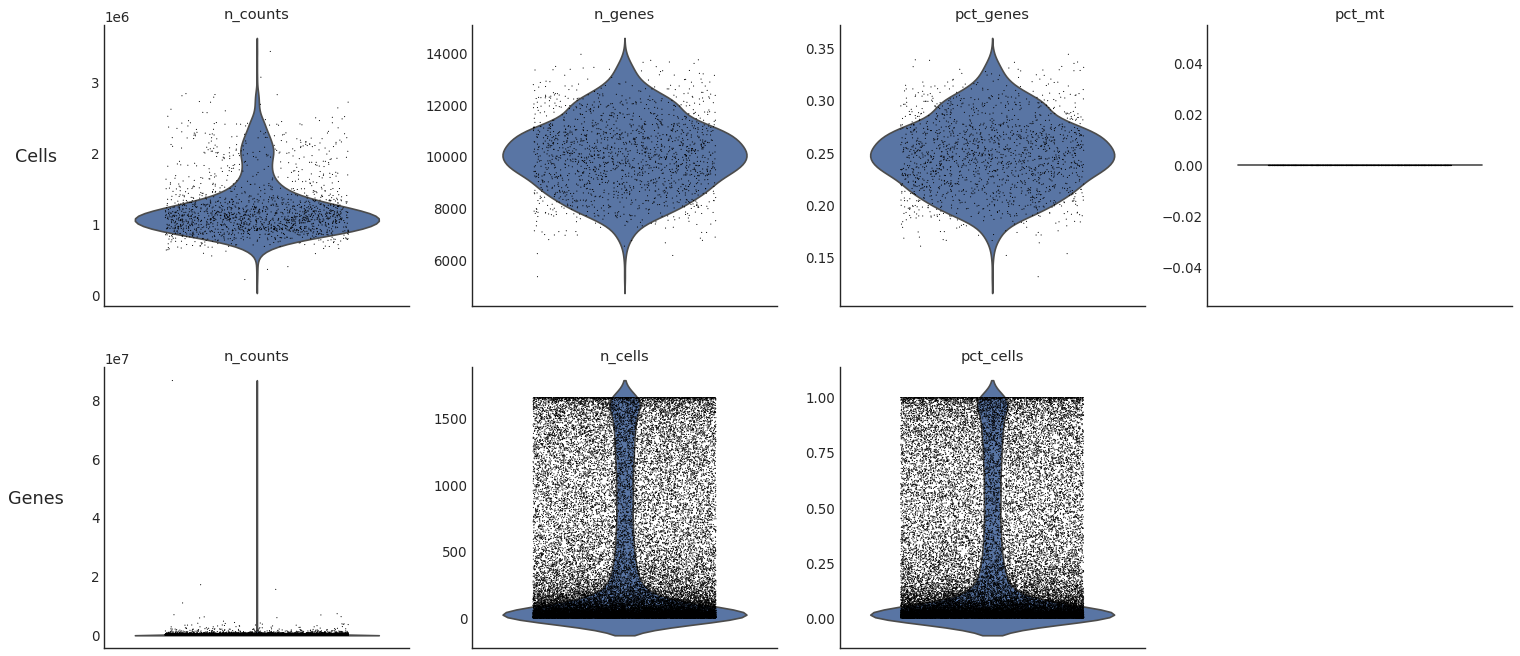

In [5]:
st.cal_qc(adata, assay='rna')
st.plot_qc(adata, jitter=0.3)

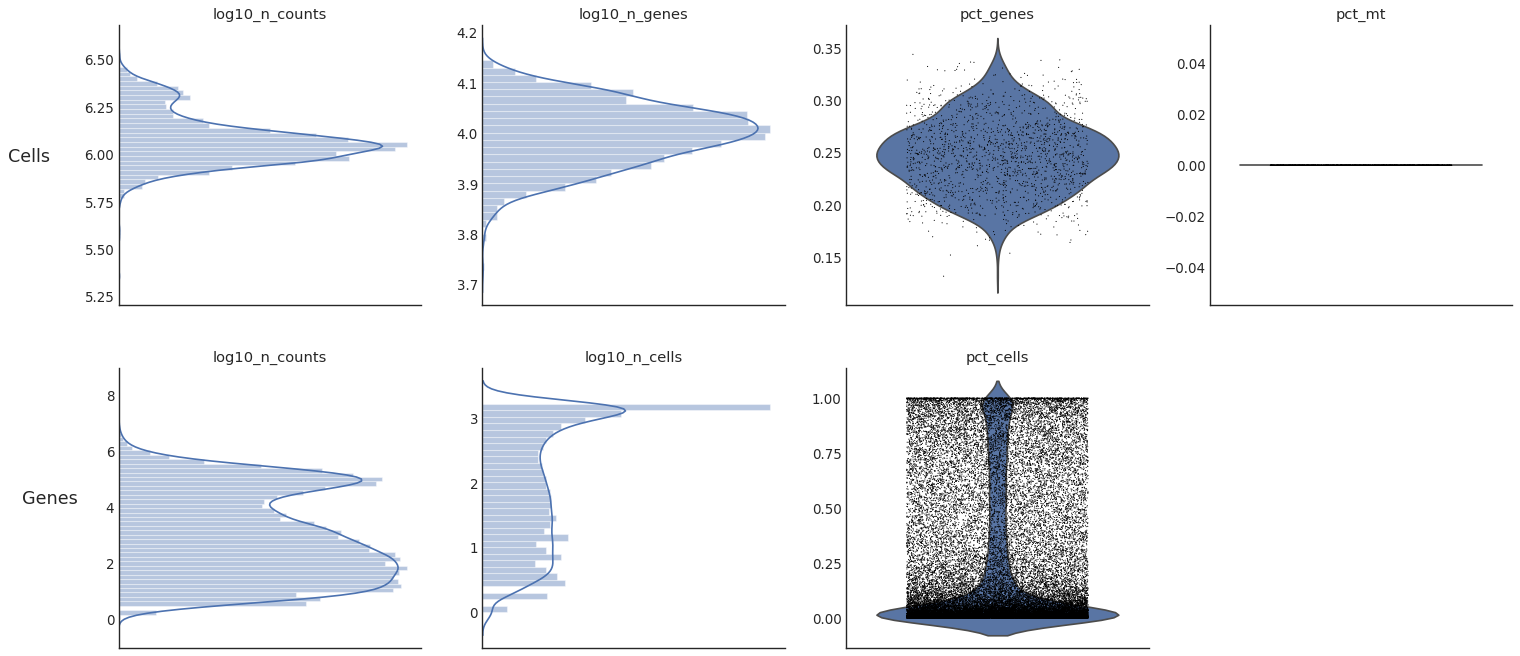

In [6]:
st.plot_qc(adata,jitter=0.3,log_scale=[0,1,4,5],hist_plot=[0,1,4,5]) 

In [7]:
st.filter_cells(adata,min_n_features= 100)
st.filter_features(adata,min_n_cells = 5)

###Normalize gene expression based on library size  
st.normalize(adata,method='lib_size')
###Logarithmize gene expression 
st.log_transform(adata)
###Remove mitochondrial genes 
st.remove_mt_genes(adata)

filter cells based on min_n_features
after filtering out low-quality cells: 
1656 cells, 40594 genes
Filter genes based on min_n_cells
After filtering out low-expressed genes: 
1656 cells, 35077 genes


1754 variable genes are selected
feature var_genes is being used ...
4 cpus are being used ...


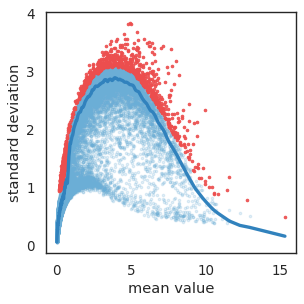

In [8]:
st.select_variable_genes(adata,loess_frac=0.01,percentile=95)
st.dimension_reduction(adata,method='se',feature='var_genes',n_components=2,n_neighbors=15,n_jobs=4)

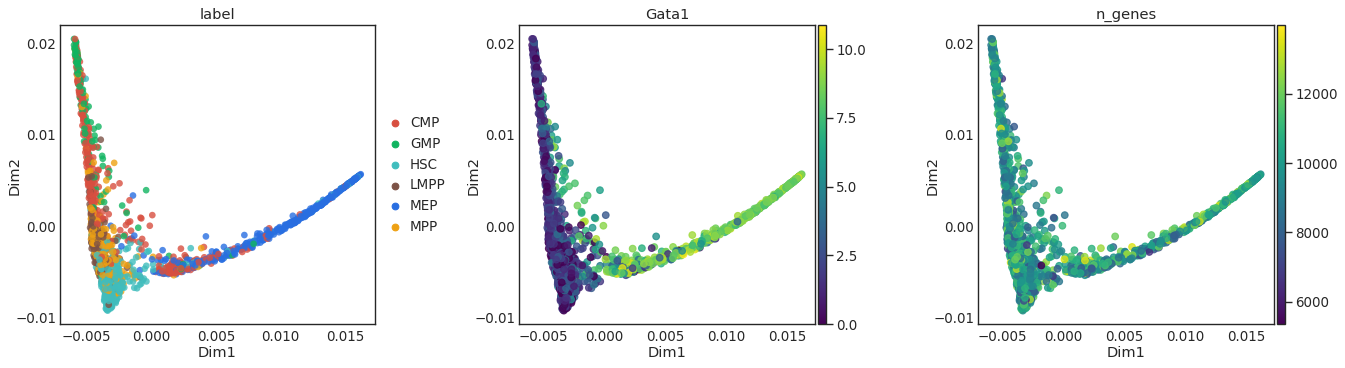

In [9]:
st.plot_dimension_reduction(adata,color=['label','Gata1','n_genes'],
                            n_components=2,show_graph=False,show_text=False)

### Trajectory Inference

In [10]:
st.seed_elastic_principal_graph(adata,n_clusters=10)

Seeding initial elastic principal graph...
Clustering...
K-Means clustering ...
The number of initial nodes is 10
Calculatng minimum spanning tree...
Number of initial branches: 3


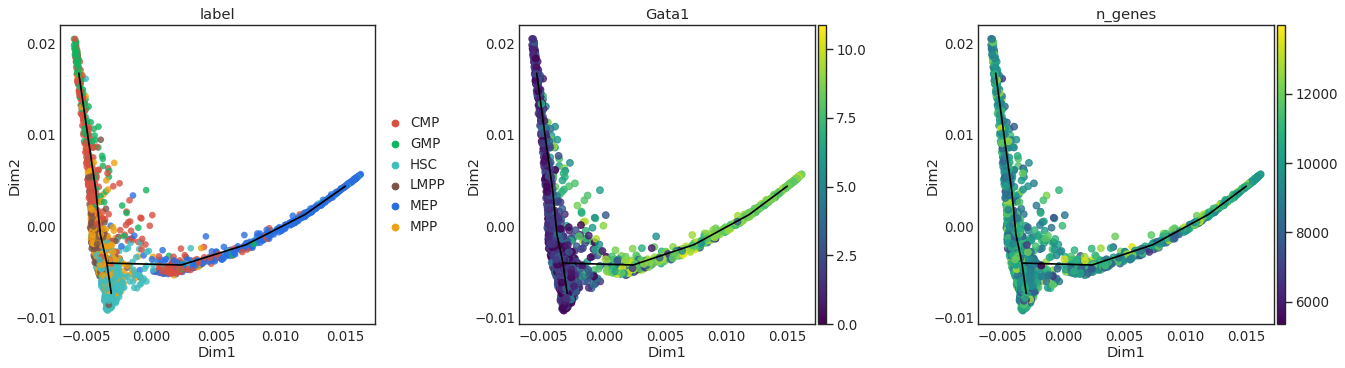

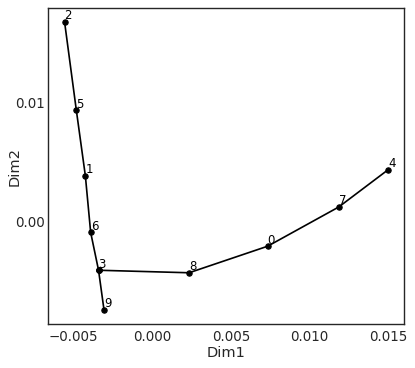

In [11]:
st.plot_dimension_reduction(adata,color=['label','Gata1','n_genes'],n_components=2,show_graph=True,show_text=False)
st.plot_branches(adata,show_text=True)

In [12]:
st.elastic_principal_graph(adata,epg_alpha=0.01,epg_mu=0.05,epg_lambda=0.05)

Learning elastic principal graph...
[1]
 "Constructing tree 1 of 1 / Subset 1 of 1"


[1]
 "Computing EPG with 50 nodes on 1656 points and 2 dimensions"


[1]
 "Using a single core"


Nodes = 
10
 
11
 
12
 
13
 
14
 
15
 
16
 
17
 
18
 
19
 
20
 
21
 
22
 
23
 
24
 
25
 
26
 
27
 
28
 
29
 
30
 
31
 
32
 
33
 
34
 
35
 
36
 
37
 
38
 
39
 
40
 
41
 
42
 
43
 
44
 
45
 
46
 
47
 
48
 
49
 


BARCODE	ENERGY	NNODES	NEDGES	NRIBS	NSTARS	NRAYS	NRAYS2	MSE	MSEP	FVE	FVEP	UE	UR	URN	URN2	URSD

1||50
	
2.877e-06
	
50
	
49
	
46
	
1
	
0
	
0
	
6.771e-07
	
6.225e-07
	
0.9921
	
0.9927
	
2.125e-06
	
7.514e-08
	
3.757e-06
	
0.0001879
	
0


10.71 sec elapsed

[[1]]



Number of branches after learning elastic principal graph: 3


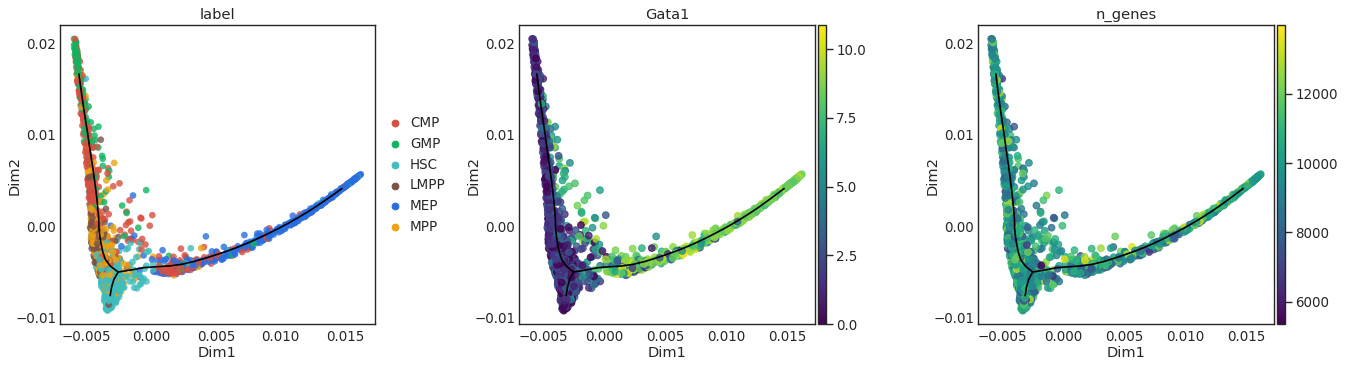

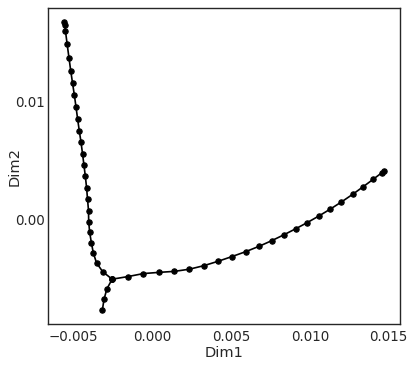

In [13]:
st.plot_dimension_reduction(adata,color=['label','Gata1','n_genes'],n_components=2,show_graph=True,show_text=False)
st.plot_branches(adata,show_text=False)

In [14]:
# #adjust trajectories (optional)
# st.optimize_branching(adata,incr_n_nodes=30)
# st.plot_dimension_reduction(adata,show_graph=True,show_text=False)
# st.plot_branches(adata,show_text=False)

# st.prune_elastic_principal_graph(adata,epg_collapse_mode='EdgesNumber',epg_collapse_par=2)
# st.plot_dimension_reduction(adata,show_graph=True,show_text=False)
# st.plot_branches(adata,show_text=False)

# st.shift_branching(adata,epg_shift_mode='NodeDensity',epg_shift_radius=0.1,epg_shift_max=3)
# st.plot_dimension_reduction(adata,show_graph=True,show_text=False)
# st.plot_branches(adata,show_text=False)

Extending leaves with additional nodes ...
Number of branches after extending leaves: 3


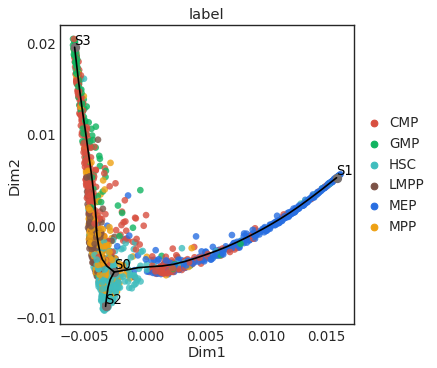

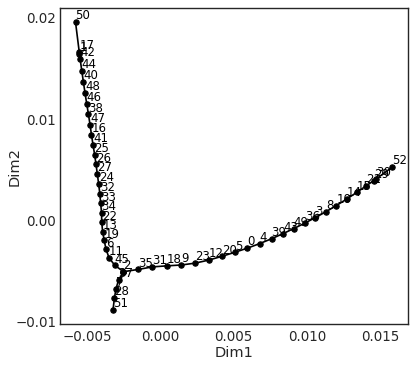

In [15]:
st.extend_elastic_principal_graph(adata, epg_ext_mode='WeigthedCentroid',epg_ext_par=0.8)
st.plot_dimension_reduction(adata,color=['label'],n_components=2,show_graph=True,show_text=True)
st.plot_branches(adata,show_text=True)

### Trajectory visualization: flat tree

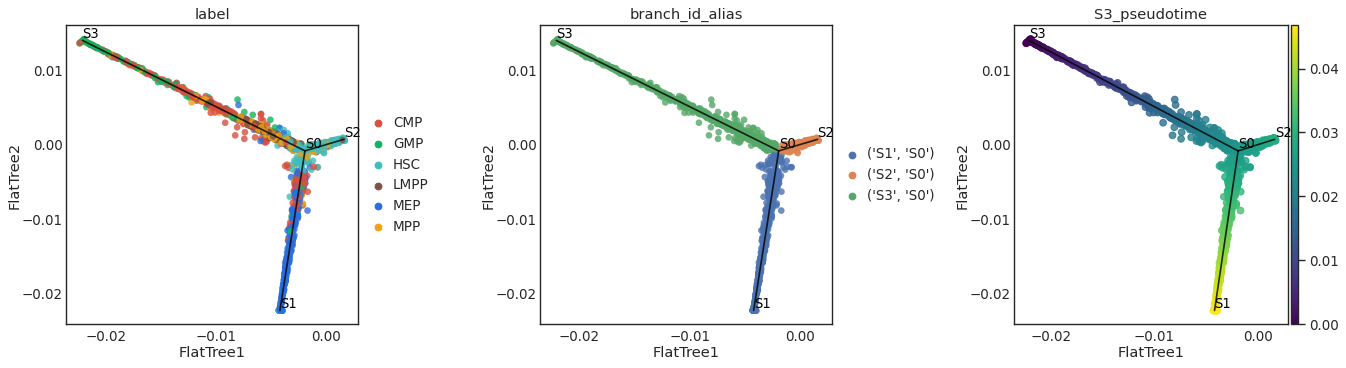

In [16]:
st.plot_flat_tree(adata,color=['label','branch_id_alias','S3_pseudotime'],
                  dist_scale=0.5,show_graph=True,show_text=True)

### Stream plot at single cell level

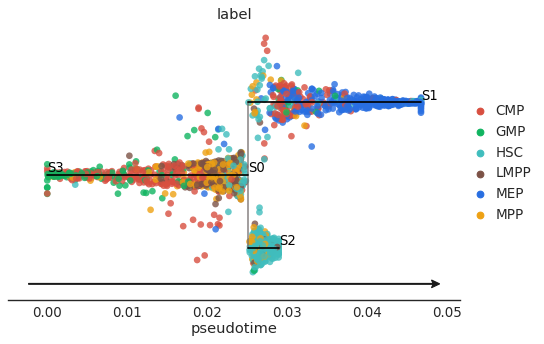

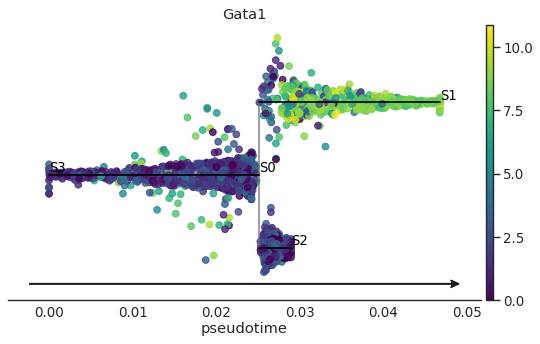

In [17]:
st.plot_stream_sc(adata,root='S3',color=['label','Gata1'],
                  dist_scale=0.3,show_graph=True,show_text=True)

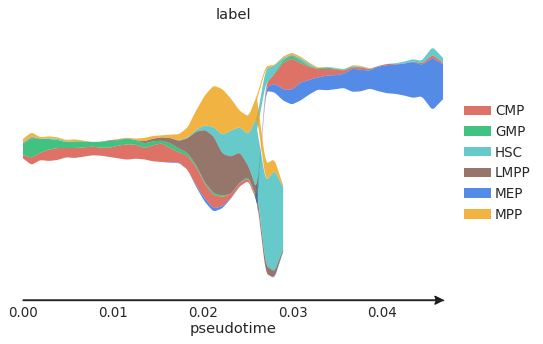

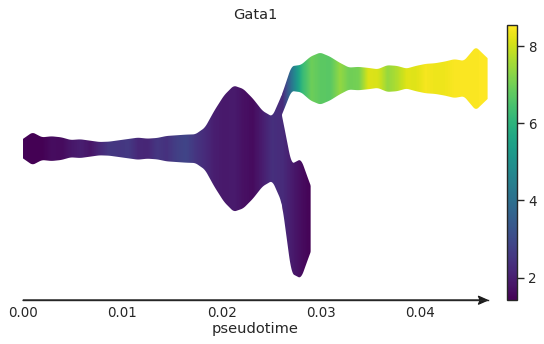

In [18]:
st.plot_stream(adata,root='S3',color=['label','Gata1'])

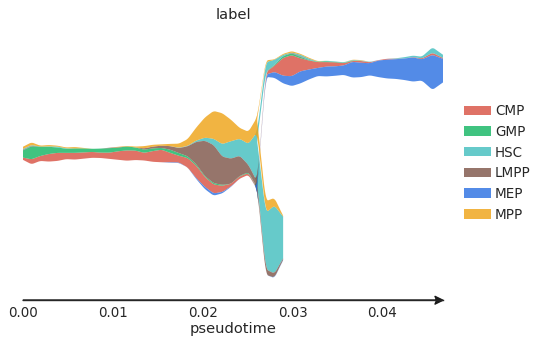

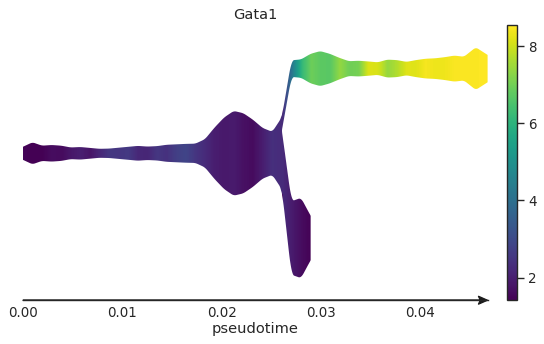

In [19]:
st.plot_stream(adata,root='S3',color=['label','Gata1'],dist_scale=0.5,factor_num_win=1.5,preference=['S0'])

### Detect marker genes for each leaf branch

In [20]:
st.detect_leaf_markers(adata,marker_list=adata.uns['var_genes'],cutoff_zscore=1.0,cutoff_pvalue=0.01,
                       root='S3',n_jobs=4)
adata.uns['leaf_markers_all'].head()

Scanning the specified marker list ...
Filtering out markers that are expressed in less than 5 cells ...
4 cpus are being used ...
1754 markers are being scanned ...


/home/mwu/miniconda3/envs/stream/lib/python3.6/site-packages/stream/scikit_posthocs.py:169: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray

/home/mwu/miniconda3/envs/stream/lib/python3.6/site-packages/stream/scikit_posthocs.py:185: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



,zscore,H_statistic,H_pvalue,S3S0_pvalue,S0S1_pvalue,S0S2_pvalue
H2afy,1.40199,1030.26,1.91647e-224,1,1.81622e-317,3.05131e-199
Emb,1.17244,988.755,1.97009e-215,1,0,1.80657e-83
Cd34,1.17836,973.957,3.2208e-212,1,4.49758e-318,9.66153e-87
Mfsd2b,1.4127,941.897,2.9495e-205,6.39662e-273,1,2.49641e-210
Cd53,1.32982,926.184,7.61542e-202,1,9.31642e-290,4.26361e-99


### Detect transition genes for each branch

In [21]:
st.detect_transition_markers(adata,marker_list=adata.uns['var_genes'],cutoff_spearman=0.4,cutoff_logfc=0.25,
                             root='S3',n_jobs=4)

Scanning the specified marker list ...
Importing precomputed scaled marker expression matrix ...
1754 markers are being scanned ...


In [22]:
adata.uns['transition_markers']['S1', 'S0'].head()

KeyError: ('S1', 'S0')

In [ ]:

st.plot_transition_markers(adata,fig_size=(10,5))

### Detect marker genes that are differentially expressed between pairs of branches

In [ ]:
st.detect_de_markers(adata,marker_list=adata.uns['var_genes'],cutoff_zscore=1,cutoff_logfc=0.25,
                     root='S3',n_jobs=4)

In [ ]:
adata.uns['de_markers_greater'][(('S1', 'S2'), ('S1', 'S0'))].head()

In [ ]:
# st.plot_de_markers(adata)

### detect cell population-specific markers

In [ ]:
st.detect_markers(adata,ident='label',marker_list=adata.uns['var_genes'],cutoff_zscore=1.0,cutoff_pvalue=0.01)

In [ ]:
import scanpy as sc

sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80, facecolor='white')

sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata, log=True)
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)


In [ ]:
sc.tl.umap(adata)
sc.pl.umap(adata, color='label', legend_loc='on data')

In [ ]:
st.write(adata, file_name='../data/stream_adata.pklz')